## Machine Learning Assignment 4 Coding Part

This Jupyter Notebook contains the coding part of Assignment 4. Please enter your name and student ID here:

* Name: Ziyu XIE (谢子钰)
* StudentID: 121090642

### Overview

In the coding part of Assignment 4, you'll complete the following four tasks:

* **Task 1**: Implement $k$​​​-means.
* **Task 2**: Implement $k$-means++ initialization.
* **Task 3**: Implement a Gaussian Mixture Model.

The following code is incomplete, and you are required to fill in the missing parts. Please feel free to define your own functions or modify the functions given if needed. You may not use off-the-shelf libraries for all three tasks.

### Data Format

We will be working with a toy dataset with features in $\mathbb R^2$. Before you begin, download the following files.
* `train.txt` the training set, containing 4800 samples.
* `dev.txt` the development set, containing 800 samples.

Each line of the files stores a sample in the format `feature_1,feature_2` .


In [1]:
import matplotlib.pyplot as plt
import torch
import numpy as np
from numpy import ndarray
from typing import Tuple, Union, Type, Dict

d:\Programming_Language\anaconda3\envs\cuda102_pv38\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def read_file(file_path: str, types: Tuple[Type, ...]) -> Tuple[ndarray, ...]:
    """Read a text file with lines containing comma separated numerical values.
    Args:
        file_path (str): The file path.
        types (Tuple[Type]): The types of each column, for example, (float, float, int).
    Returns:
        columns (Tuple[ndarray, ...]): Numpy arrays of shape [N_lines].
    """
    with open(file_path, "r") as f:
        items = [line.strip().split(",") for line in f.readlines()]
        items = [tuple(type(e) for type, e in zip(types, t)) for t in items]
    columns = list(zip(*items))
    return tuple(np.asarray(c) for c in columns)


# Load the dataset from files
train_x1, train_x2 = read_file("train.txt", (float, float))
train_x = np.stack((train_x1, train_x2), axis=1)
dev_x1, dev_x2 = read_file("dev.txt", (float, float))
dev_x = np.stack((dev_x1, dev_x2), axis=1)

### Visualization of the Training Set


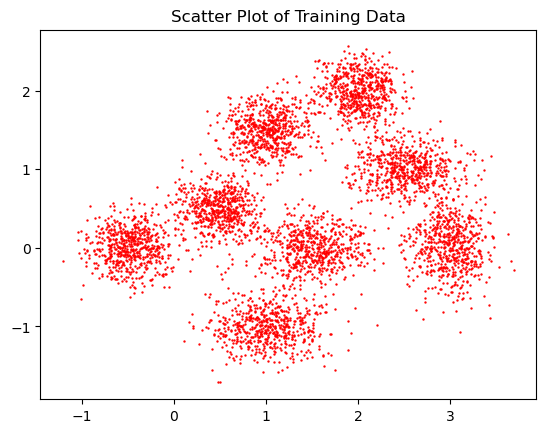

In [3]:
plt.scatter(train_x[:, 0], train_x[:, 1], c="red", s=0.5)
plt.title("Scatter Plot of Training Data")
plt.show()

### Task 1: Implement $k$-means

For $\mathbf x \in \mathbb R^D$ and finite set $\mathcal C \subset \mathbb R^D$ define $d(\mathbf x, \mathcal C) := \min_{\mathbf c \in \mathcal C} \|\mathbf x - \mathbf c\|_2$.

For finite set $\mathcal X \subset \mathbb R^D$ and finite set $\mathcal C \subset \mathbb R^D$ define $\phi(\mathcal X, \mathcal C) := \sum_{\mathbf x \in \mathcal X} d^2(\mathbf x, \mathcal C)$.

Given $\mathcal X = \{\mathbf x_1, \cdots, \mathbf x_N\} \subset \mathbb R^D$, $k$-means optimizes $\mathcal C \subset \mathbb R^D$, where $|\mathcal C| = K$, to minimize the following loss:
$$
\mathcal L(\mathcal C) = \phi(\mathcal X, \mathcal C) = \sum_{\mathbf x \in \mathcal X} \min_{\mathbf c \in \mathcal C} \|\mathbf x - \mathbf c\|_2^2
$$

#### Subtasks

1. Implement the `solve_k_means()` function in the following code block.
2. Plot the loss $\mathcal L$ as a function the number of updates to $\mathcal C$.
3. Generate a scatter plot of the training samples and cluster centers, after $k$-means converges to a **global minimum**.
4. Run $k$-means multiple times. How frequently does the algorithm converge to a global minimum?


##### Subtask 1: `solve_k_means()` Implementation

In [3]:
def solve_k_means(
    x: ndarray, c: ndarray, *, max_step: int = 10000
) -> Tuple[ndarray, ndarray, list]:
    """K-means solver. Given K initial cluster centers, update c iteratively.
    Note:
        - You may change the function signature.
        - Please try your best to write vectorized code (i.e. avoid for loops over indices).
        - Design some criterion for stopping the iteration.
    Args:
        x (ndarray[float]): shape [N, D], storing N data samples. D is the feature dimension.
        c (ndarray[float]): shape [K, D], storing K initial cluster centers.
        max_step (int): Maximum number of steps in $k$-means iteration.
    Returns:
        c (ndarray[float]): shape [K, D], updated K cluster centers after iterations.
        index (ndarray[int]): shape [N], the index of the nearest cluster center of
            each sample, in range {0, ..., K - 1}.
    """
    # raise NotImplementedError()
    ##############################################################
    # TODO: Enter your code here                                 #
    ##############################################################
    N, D = x.shape
    K = c.shape[0]
    tol = 1e-04

    res_c = None
    res_idx = None
    pre_c = c.copy()
    loss_lst = []

    for _ in range(max_step):
        # extend the shape to [N, K, D] so that we can derive dis_arr with shape [N, K]
        data_points_ext = x[:, np.newaxis, :]
        cluster_centers_ext = pre_c[np.newaxis, :, :]
        points_cents_dis_arr = np.sqrt(
            np.sum((data_points_ext - cluster_centers_ext)**2, axis=2))
        # get the result (cluster) idx of each data point
        res_idx = np.argmin(points_cents_dis_arr, axis=1)
        # use boolean arr generated by res_idx == k to get points from x
        # then use np.mean to calculate the center
        # here I think use for k loop is easier than vectorized code
        res_c = np.array([np.mean(x[res_idx == k], axis=0)
                          for k in range(K)])
        # calculate loss
        loss = np.sum([np.sum(np.sqrt((x[res_idx == k] - res_c[k])**2))
                       for k in range(K)])
        loss_lst.append(loss)

        # using norm and tolerance as the criterion
        if (np.sqrt(np.sum((res_c - pre_c)**2)) < tol):
            break
        pre_c = res_c.copy()

    return res_c, res_idx, loss_lst

In [4]:
# Random (standard Normal) initialization:
def standard_normal_initialization(K: int) -> ndarray:
    """Standard normal initialization of K cluster centers.
    Args:
        K (int): number of cluster centers.
    Returns:
        c (ndarray): shape [K, 2], K initial cluster centers.
    """
    return np.random.randn(K, 2)

In [9]:
# Run k-means with random initialization:
init_c = standard_normal_initialization(8)
updated_c, index, loss_lst = solve_k_means(train_x, init_c, max_step=1000)

##### Subtask 2: Plot the Loss Function

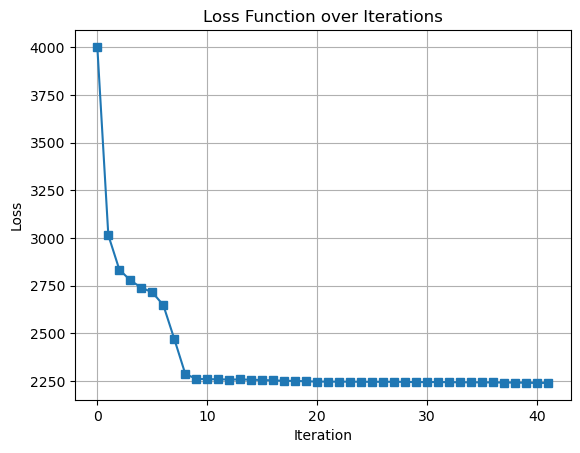

In [10]:
plt.plot(loss_lst, marker='s') 
plt.title('Loss Function over Iterations') 
plt.xlabel('Iteration') 
plt.ylabel('Loss') 
plt.grid(True) 
plt.show() 

##### Subtask 3 & 4
Generate a scatter plot of the training samples and cluster centers Subtask

Run $k$-means multiple times. How frequently does the algorithm converge to a global minimum?

In [11]:
from tqdm import tqdm

updated_c_lst = []
idx_lst = []
final_loss_lst = []

global_updated_c = None
global_idx = None
global_final_loss = None

# use 1000 clustering times to find the global minimum
for k in tqdm(range(100)):

    # Run k-means with random initialization:
    init_c = standard_normal_initialization(8)
    updated_c, index, loss_lst_1 = solve_k_means(train_x, init_c, max_step=1000)
    # record all info
    updated_c_lst.append(updated_c)
    idx_lst.append(index)
    final_loss_lst.append(loss_lst_1[-1])
    # record the global minimun
    if (global_final_loss == None):
        global_updated_c = updated_c
        global_idx = index
        global_final_loss = loss_lst_1[-1]
    else:
        if (loss_lst_1[-1] < global_final_loss):
            global_updated_c = updated_c
            global_idx = index
            global_final_loss = loss_lst_1[-1]

100%|██████████| 100/100 [02:16<00:00,  1.36s/it]


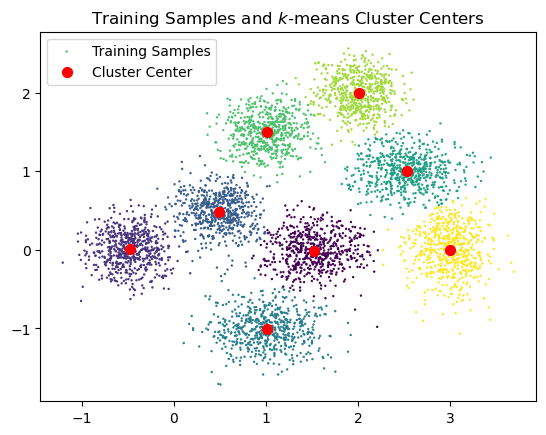

In [12]:
# Plot out the training samples and the cluster centers.
def plotCluster(train_x, index, updated_c):

    plt.scatter(train_x[:, 0], train_x[:, 1], c=index,
                s=0.5, label="Training Samples")
    plt.scatter(updated_c[:, 0], updated_c[:, 1], c="red",
                s=50, label="Cluster Center", marker="o")

    plt.legend()
    plt.title("Training Samples and $k$-means Cluster Centers")
    plt.show()
    
plotCluster(train_x, global_idx, global_updated_c)


In [13]:
# find the frequency of global minimum

count = 0

for k in range(len(final_loss_lst)):
    dis = np.sqrt(np.sum((global_updated_c - updated_c_lst[k])**2))
    if dis < 5: # this is a hyper parameter, which can be redetermined
        count += 1

print(f"The frequency of global minimun is {count / len(final_loss_lst)}")

The frequency of global minimun is 0.12


### Task 2: Implement $k$-means++

$k$-means is sensitive to its initialization, and a random initialization of $\mathbf c$ often results in convergence to a local minimum. $k$-means++ is an improved initialization method that often leads to better convergence. Read more about it in [Scalable K-Means++](https://theory.stanford.edu/~sergei/papers/vldb12-kmpar.pdf).

**(Algorithm)** Given $\mathcal X$, $k$-means++ generates a set of $k$ vectors $\mathcal I$ in $\mathbb R^D$ using the following steps:
1. First, randomly pick a sample $\mathbf x$ from $\mathcal X$. And set $\mathcal I := \{\mathbf x\}$.
2. While $|\mathcal I| < k$. Sample $\mathbf x \in \mathcal X$ with probability $p(\mathbf x) := d^2(\mathbf x, \mathcal I) / \phi(\mathcal X, \mathcal I)$. And add the sampled $\mathbf x$ to set $\mathcal I$.

#### Subtasks

1. Implement $k$-means++ initialization algorithm.
2. Compare the loss $\mathcal L$ after convergence with standard normal initialization and $k$-means++ initialization.
3. Compare the convergence speed with random and $k$-means++ initialization.


##### Subtasks 1: Implement k-means++ initialization algorithm

In [14]:
def k_means_pp_initialization(x: ndarray, K: int) -> ndarray:
    """K-means++ initialization method.
    Args:
        x (ndarray): shape [N, D], storing N data samples. D is the feature dimension.
        K (int): Number of cluster centers.
    Returns:
        c (ndarray): shape [K, D], K initial cluster centers generated by K-means++.
    """
    # raise NotImplementedError()
    ##############################################################
    # TODO: Enter your code here                                 #
    ##############################################################
    N, D = x.shape
    c = np.empty((K, D))
    # randomly pick one sample
    c[0] = x[np.random.randint(0, N-1)]
    # find remain points
    k = 1
    while (k < K):
        data_points_ext = x[:, np.newaxis, :]  # N, 1, D
        cluster_centers_ext = c[np.newaxis, :k, :]  # 1, k, D
        points_cents_dis_arr = np.sqrt(  # N, k
            np.sum((data_points_ext - cluster_centers_ext)**2, axis=2))
        # get the result (cluster) idx of each data point
        # res_idx = np.argmin(points_cents_dis_arr, axis=1) # N, 1
        d_sq_x_I = np.min(points_cents_dis_arr, axis=1)  # N, 1
        fi_x_I = np.sum(d_sq_x_I)
        prob = d_sq_x_I / fi_x_I
        selected_index = np.random.choice(x.shape[0], p=prob)
        selected_new_x = x[selected_index]
        if (not np.array_equal(selected_new_x, c[k-1])):
            c[k] = selected_new_x
            k += 1
        
    return c

##### Subtask 2 & 3: 
1. Compare the loss $\mathcal L$ after convergence with standard normal initialization and $k$-means++ initialization. 
2. Compare the convergence speed with random and $k$-means++ initialization.

In [25]:
# Initialize the cluster centers with standard normal, then do k-means updates.
init_c_1 = standard_normal_initialization(8)
updated_c_1, index_1, loss_lst_1 = solve_k_means(train_x, init_c_1, max_step=1000)

# Initialize the cluster centers with k-means++, then do k-means updates.
init_c_2 = k_means_pp_initialization(train_x, 8)
updated_c_2, index_2, loss_lst_2 = solve_k_means(train_x, init_c_2, max_step=1000)

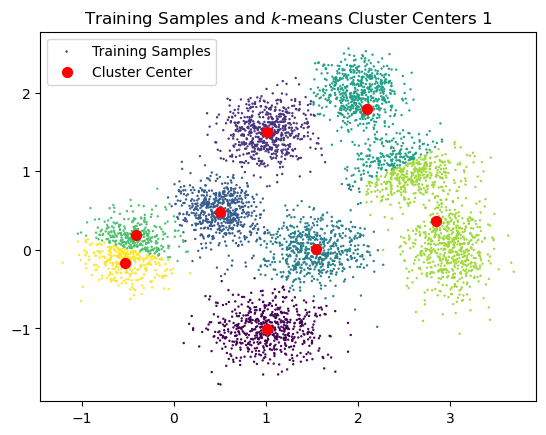

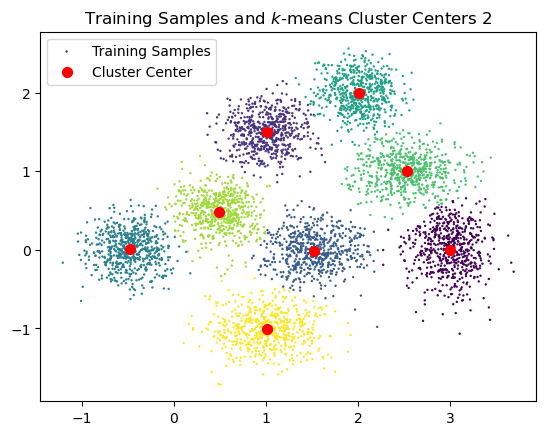

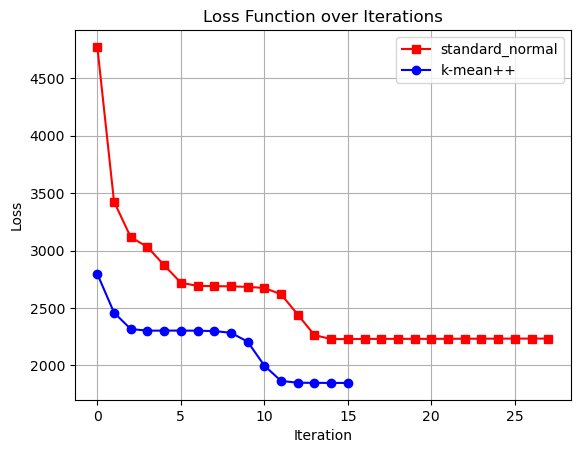

In [26]:
# compare the loss L after convergence
# Plot out the training samples and the cluster centers.
def plotClusterOrder(order, train_x, index, updated_c):

    plt.scatter(train_x[:, 0], train_x[:, 1], c=index,
                s=0.5, label="Training Samples")
    plt.scatter(updated_c[:, 0], updated_c[:, 1], c="red",
                s=50, label="Cluster Center", marker="o")

    plt.legend()
    plt.title(f"Training Samples and $k$-means Cluster Centers {order}")
    plt.show()
    
def plotLossCompare(loss_lst_1, loss_lst_2):
    plt.plot(loss_lst_1, marker='s', color='red', label='standard_normal') 
    plt.plot(loss_lst_2, marker='o', color='blue', label='k-mean++') 
    plt.title('Loss Function over Iterations') 
    plt.xlabel('Iteration') 
    plt.ylabel('Loss') 
    plt.legend()
    plt.grid(True) 
    plt.show() 
    
plotClusterOrder(1, train_x, index_1, updated_c_1)
plotClusterOrder(2, train_x, index_2, updated_c_2)
plotLossCompare(loss_lst_1, loss_lst_2)

The compare result:
1. There is no big difference between the losses after convergence with standard normal initialization and $k$-means++ initialization, if they converge to the same or similar local minimum. But if they are not the same, the kmeans++ initialization has a larger probability to converge to the global minimum. (I have tried this multiple times).
2. The convergence speeds with random and $k$-means++ initialization are different. Obviously, the latter converges faster because the loss decreases faster and the termination condition is reached in fewer iterations.

### Task 3: Implement a Gaussian Mixture Model

In this task, you will implement the Expectation-Maximization (EM) algorithm for learning a Gaussian Mixture Model (GMM). Our GMM in $\mathbb R^2$ has a density given by:

$$
p(x) = \sum_{k = 1}^K \pi_k \mathcal N(x| \mu_k, \Sigma_k), \quad \mu_k \in \mathbb R^2, \quad \Sigma_k \in \mathbb R^{2 \times 2}
$$

#### Subtasks

1. Implement EM algorithm. Hint: initialize the Gaussian means with $k$-means++ for better convergence.
2. Use the provided `plot_gmm_contour` function to generate a 2D contour plot of the GMM density $p(x)$ after the log likelihood convergence to a global maximum. You may use `gmm_log_prob` to compute log probability of the GMM.
3. Report the log-likelihood on the training set and development set.


 11%|█         | 108/1000 [00:26<03:41,  4.04it/s]


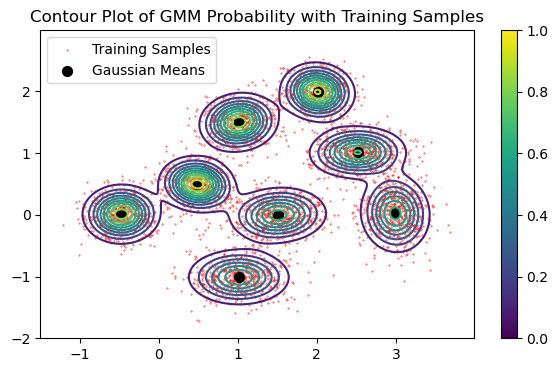

Final log-likelihood: -9693.226175988102
Development set log-likelihood: -1678.0091866898674


In [36]:
##############################################################
# TODO: Enter your code here                                 #
##############################################################

import numpy as np
import matplotlib.pyplot as plt
import torch
from numpy import ndarray
from typing import Tuple, Union, Type, Dict


def EM_init(x, k):
    clusters = k_means_pp_initialization(x, k)
    conv = np.array([np.cov(x, rowvar=False) for i in range(k)])
    pi = np.full(k, 1/k)
    return clusters, conv, pi


def EM_algorithm(x, k, tol, max_iter):
    miu, sigma, pi = EM_init(x, k)
    log_likeli = None
    miu_new, sigma_new, pi_new, log_likeli_new = None, None, None, None

    for i in tqdm(range(max_iter)):
        respon = EM_E_step(x, pi, miu, sigma)
        miu_new, sigma_new, pi_new = EM_M_step(x, respon)
        log_likeli_new = evaluate(x, pi_new, miu_new, sigma_new)
        if (log_likeli != None):
            if (np.abs(log_likeli_new - log_likeli) < tol):
                break
        log_likeli = log_likeli_new
        miu, sigma, pi = miu_new, sigma_new, pi_new

    return miu_new, sigma_new, pi_new, log_likeli_new


def EM_E_step(x, pi, miu, sigma):
    K = len(pi)
    respon = np.zeros((x.shape[0], K))  # N, K
    for k in range(K):
        pi_k = pi[k]
        miu_k = miu[k]
        sigma_k = sigma[k]
        respon[:, k] = pi_k * multi_gaussian(x, miu_k, sigma_k)
    respon /= respon.sum(axis=1, keepdims=True)
    return respon

def multi_gaussian(x, mean, cov):
    num_samples = x.shape[0]
    num_dimensions = mean.size
    
    cov_inv = np.linalg.inv(cov)
    cov_det = np.linalg.det(cov)
    
    coeff = 1.0 / np.sqrt((2 * np.pi) ** num_dimensions * cov_det)
    
    probs = np.zeros(num_samples)
    
    for i in range(num_samples):
        diff = x[i] - mean
        exponent = -0.5 * np.dot(diff.T, np.dot(cov_inv, diff))
        probs[i] = coeff * np.exp(exponent)
    
    return probs


def EM_M_step(x, respon):
    N = x.shape[0]
    K = respon.shape[1]
    N_k = np.sum(respon, axis=0)  # K,
    pi_new = N_k / N
    miu_new = (respon.T @ x) / N_k[:, None]
    sigma_new = np.empty((K, x.shape[1], x.shape[1]))
    
    for k in range(K):
        X_centered = x - miu_new[k]
        sigma_k = np.dot(respon[:, k] * X_centered.T, X_centered) / N_k[k]
        sigma_new[k] = sigma_k
    
    return miu_new, sigma_new, pi_new

def gmm_log_prob(x: ndarray, pi: ndarray, mu: ndarray, sigma: ndarray) -> ndarray:
    """Batched computation of GMM log probability.
    Arg:
        x (ndarray): [..., 2]. Each sample is a vector in R^2.
        pi (ndarray): [K], mixture weights in the GMM, pi.sum() = 1.
        mu (ndarray): [K, 2], means of Gaussian components.
        sigma (ndarray): [K, 2, 2], covariance matrix of Gaussian components.
            Each sigma[k] must be symmetric positive definite.
    Returns:
        log_prob (ndarray): [...]. The log probability of each vector in x.
            Has the same shape as x after removing the last dimension of x.
    """
    mix = torch.distributions.Categorical(probs=torch.as_tensor(pi))
    normals = torch.distributions.MultivariateNormal(
        loc=torch.as_tensor(mu), covariance_matrix=torch.as_tensor(sigma)
    )
    gmm = torch.distributions.MixtureSameFamily(mix, normals)
    return gmm.log_prob(torch.as_tensor(x)).numpy()


def evaluate(x, pi, miu, sigma):
    new_log_likelihood = np.sum(gmm_log_prob(x, pi, miu, sigma))
    return new_log_likelihood


def plot_gmm_contour(x: ndarray, pi: ndarray, mu: ndarray, sigma: ndarray) -> None:
    """Generate a contour plot of the GMM probability, overlapped with a scatter plot
        of the samples in x.
    Args:
        x (ndarray): [N, 2].
        pi (ndarray): [K], mixture weights in the GMM, pi.sum() = 1.
        mu (ndarray): [K, 2], means of Gaussian components.
        sigma (ndarray): [K, 2, 2], covariance matrix of Gaussian components.
            Each sigma[k] must be symmetric positive definite.
    """
    grid_1 = np.arange(-1.5, 4, 0.01)  # [Gx]
    grid_2 = np.arange(-2, 3, 0.01)  # [Gy]
    grid_11, grid_22 = np.meshgrid(grid_1, grid_2, indexing="ij")  # [Gx, Gy]
    grid_12 = np.stack([grid_11, grid_22], axis=-1)  # [Gx, Gy, 2]

    grid_logp = gmm_log_prob(grid_12, pi, mu, sigma)  # [Gx, Gy, 2]

    # Plot the contour
    plt.figure(figsize=(7, 4))
    plt.contour(grid_1, grid_2, np.exp(
        grid_logp.transpose()), levels=10, cmap='viridis')
    plt.scatter(x[:, 0], x[:, 1], c="red", s=0.1, label="Training Samples")
    plt.scatter(mu[:, 0], mu[:, 1], c="black", s=50, label="Gaussian Means")
    plt.legend()  # Add legend
    plt.title("Contour Plot of GMM Probability with Training Samples")
    plt.colorbar()
    plt.show()


miu, sigma, pi = EM_init(train_x, 8)
# plot_gmm_contour(train_x, pi, miu, sigma)
miu, sigma, pi, log_likelihood = EM_algorithm(train_x, 8, 1e-6, 1000)

plot_gmm_contour(train_x, pi, miu, sigma)
print(f'Final log-likelihood: {log_likelihood}')

dev_log_likelihood = np.sum(gmm_log_prob(dev_x, pi, miu, sigma))
print(f'Development set log-likelihood: {dev_log_likelihood}')

In [15]:
def gmm_log_prob(x: ndarray, pi: ndarray, mu: ndarray, sigma: ndarray) -> ndarray:
    """Batched computation of GMM log probability.
    Arg:
        x (ndarray): [..., 2]. Each sample is a vector in R^2.
        pi (ndarray): [K], mixture weights in the GMM, pi.sum() = 1.
        mu (ndarray): [K, 2], means of Gaussian components.
        sigma (ndarray): [K, 2, 2], covariance matrix of Gaussian components.
            Each sigma[k] must be symmetric positive definite.
    Returns:
        log_prob (ndarray): [...]. The log probability of each vector in x.
            Has the same shape as x after removing the last dimension of x.
    """
    mix = torch.distributions.Categorical(probs=torch.as_tensor(pi))
    normals = torch.distributions.MultivariateNormal(
        loc=torch.as_tensor(mu), covariance_matrix=torch.as_tensor(sigma)
    )
    gmm = torch.distributions.MixtureSameFamily(mix, normals)
    return gmm.log_prob(torch.as_tensor(x)).numpy()

In [16]:
def plot_gmm_contour(x: ndarray, pi: ndarray, mu: ndarray, sigma: ndarray) -> None:
    """Generate a contour plot of the GMM probability, overlapped with a scatter plot
        of the samples in x.
    Args:
        x (ndarray): [N, 2].
        pi (ndarray): [K], mixture weights in the GMM, pi.sum() = 1.
        mu (ndarray): [K, 2], means of Gaussian components.
        sigma (ndarray): [K, 2, 2], covariance matrix of Gaussian components.
            Each sigma[k] must be symmetric positive definite.
    """
    grid_1 = np.arange(-1.5, 4, 0.01)  # [Gx]
    grid_2 = np.arange(-2, 3, 0.01)  # [Gy]
    grid_11, grid_22 = np.meshgrid(grid_1, grid_2, indexing="ij")  # [Gx, Gy]
    grid_12 = np.stack([grid_11, grid_22], axis=-1)  # [Gx, Gy, 2]

    grid_logp = gmm_log_prob(grid_12, pi, mu, sigma)  # [Gx, Gy, 2]

    # Plot the contour
    plt.figure(figsize=(7, 4))
    plt.contour(grid_1, grid_2, np.exp(
        grid_logp.transpose()), levels=10, cmap='viridis')
    plt.scatter(x[:, 0], x[:, 1], c="red", s=0.1, label="Training Samples")
    plt.scatter(mu[:, 0], mu[:, 1], c="black", s=50, label="Gaussian Means")
    plt.legend()  # Add legend
    plt.title("Contour Plot of GMM Probability with Training Samples")
    plt.colorbar()
    plt.show()